In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn import tree 

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scio
import hiddenlayer as h
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot

import datetime
import os 

import sys
from utils.reuse import *
from utils.networks import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# 以下是检查点路径
# 请在当前环境下 CMD 输入python -m visdom.server 或 visdom 启动监视器
# 数据处理现在已移至 emgDataprocess.ipynb
ckpDir = './/ckp//opg//oth//'
if not os.path.exists(ckpDir):
    os.makedirs(ckpDir)

ckpDir_auc = './/ckp//opg//auc//'
if not os.path.exists(ckpDir_auc):
    os.makedirs(ckpDir_auc)

def get_current_time():
    return datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
print(get_current_time())

timeForSave = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

2022_02_05_16_44_20


In [3]:
# 以下是 visdom 监视窗口初始化，实现每次启用时重新加载，这里只写了 NameError 以防其他错误不能被发现
class visdom_account:
    def __init__(self):    
        self.port = 8097
        self.server = "http://localhost"
        self.base_url = "/"
        self.username = "admin"
        self.passward = "1234"
        self.evns = "train"
viz_acnt = visdom_account()
vislogDir = './/vislog//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
def viz_init():
    try:
        viz
    except NameError:
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has started')
    else:
        viz.close()
        del viz
        print('last visdom session closed')
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has restarted')
    return viz
viz = viz_init()

Setting up a new session...


visdom has started


In [2]:
%load_ext autoreload
%autoreload 2
# GAN 模型搭建
# 潜在张量大小,32
latent_size = 8
# 输出通道数
n_channel = 10
# 生成网络隐藏层大小
n_g_feature = 64

gnet = GAN_Gen_alpha(latent_size = 8,n_g_feature = 64,n_channel = 10).to(device)
# print(gnet)
summary(gnet,(1,1,8),batch_size = 1,device = "cuda")
# 鉴别网络隐藏层大小
# 32,
n_d_feature = 64
dnet = GAN_Dis_alpha(n_channel = n_channel,n_d_feature = n_d_feature).to(device)
# print(dnet)
summary(dnet,(1,1,10),batch_size = 1,device = "cuda")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                     [1, 8]               0
            Linear-2                   [1, 128]           1,152
       BatchNorm1d-3                   [1, 128]             256
              ReLU-4                   [1, 128]               0
         Dropout2d-5                   [1, 128]               0
            Linear-6                   [1, 256]          33,024
       BatchNorm1d-7                   [1, 256]             512
              ReLU-8                   [1, 256]               0
         Dropout2d-9                   [1, 256]               0
           Linear-10                    [1, 10]           2,570
Total params: 37,514
Trainable params: 37,514
Non-trainable params: 0
----------------------------------------------------------------
Input si

In [7]:
def weights_init(m):
    if type(m) in [nn.ConvTranspose2d, nn.Conv2d]:
        init.xavier_normal_(m.weight)
    elif type(m) == nn.BatchNorm2d:
        init.normal_(m.weight, 1.0, 0.02)
        init.constant_(m.bias, 0)

gnet.apply(weights_init)
dnet.apply(weights_init)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=10, out_features=128, bias=True)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Dropout2d(p=0.2, inplace=False)
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout2d(p=0.2, inplace=False)
  (9): Linear(in_features=64, out_features=1, bias=True)
)

In [3]:
 
dataarray = np.load('../data/OpenganDatafea_full_2222.npy',allow_pickle=True)
GANdataset = dataarray.item()
print(type(GANdataset))
traindata = GANdataset['Xtrain']
trainlabel = GANdataset['Ytrain']
testdata = GANdataset['Xtest']
testlabel = GANdataset['Ytest']

trainlabel = trainlabel[:,0]
testlabel = testlabel[:,0]
# trainunknownc_label = trainunknownc_label[:,0]
# print(type(trainlabel))
train_set = EMGDataset_1D(traindata, trainlabel)
test_set = EMGDataset_1D(testdata, testlabel)
# train_unknown = EMGDataset(trainunknown_data,trainunknownc_label)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, pin_memory=True,
#                                             num_workers=3)
val_set = EMGDataset_1D(GANdataset['Xval'],GANdataset['Yval'])
val_lb = GANdataset['val_nlb']

sample = next(iter(test_set))
print(sample)

<class 'dict'>
(tensor([ 5.8117, -4.4726, -6.0694, -3.7898, -9.0487, -5.5877, -6.4244, -1.4868,
        -2.1726,  4.7466]), 0)


In [10]:
# GAN 训练,120
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
# 损失
criterion = nn.BCEWithLogitsLoss().to(device)
# criterion = F.cross_entropy()

# 优化器
goptimizer = torch.optim.Adam(gnet.parameters(),
        lr=0.0008*1.5, betas=(0.5, 0.999))
doptimizer = torch.optim.Adam(dnet.parameters(),
        lr=0.004*3, betas=(0.5, 0.999))
g_lr_schedule = torch.optim.lr_scheduler.StepLR(\
        goptimizer, 2000, gamma=0.95, last_epoch=-1)
d_lr_schedule = torch.optim.lr_scheduler.StepLR(\
        doptimizer, 2000, gamma=0.95, last_epoch=-1)
# 用于测试的固定噪声,用来查看相同的潜在张量在训练过程中生成图片的变换
# batch_size = 512
# fixed_noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
# 初始化 visdom 
viz.close()
viz = viz_init()
vislogDir = './/vislog//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
viz = Visdom(env=viz_acnt.evns, log_to_filename=vislogDir+'vislog_'+get_current_time())
vizx = 0
viz.text('MONITOR: Show train process~~',win='Monitor', opts = {'title':'ProcessMonitor',},)
# AUC值
auc_current = 0
auc_max = 0
# 训练过程
epoch_num = 40000
for epoch in range(epoch_num):
    viz.text('ep'+str(epoch+1)+' start',win='Monitor',opts = {'title':'ProcessMonitor',},)
    dnet.to(device)
    for batch in train_loader:
        # 载入本批次数据
        # real_images, _ = data
        # viz.text('load data',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        rimages, rlabels = batch
        rimages = rimages.to(torch.float32)
        rlabels = rlabels.long()
        batch_size = rimages.size(0)
        # batch_size = 1344
        # viz.text('training',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        # 训练鉴别网络
        dnet.train()
        gnet.train()
        labels = torch.ones(batch_size) # 真实数据对应标签为1
        preds = dnet(rimages.to(device)) # 对真实数据进行判别
        preds = preds.reshape(-1)

        dloss_real = criterion(preds.to(device), labels.to(device)) # 真实数据的鉴别器损失
        dmean_real = preds.sigmoid().mean()
                # 计算鉴别器将多少比例的真数据判定为真,仅用于输出显示

        noises = torch.randn(batch_size, latent_size, 1, 1) # 潜在噪声
        fake_images = gnet(noises.to(device)) # 生成假数据
        labels = torch.zeros(batch_size) # 假数据对应标签为0
        fake = fake_images.detach()
                # 使得梯度的计算不回溯到生成网络,可用于加快训练速度.删去此步结果不变
        preds = dnet(fake) # 对假数据进行鉴别
        preds = preds.view(-1)
        dloss_fake = criterion(preds.to(device), labels.to(device)) # 假数据的鉴别器损失
        dmean_fake = preds.sigmoid().mean()
                # 计算鉴别器将多少比例的假数据判定为真,仅用于输出显示

        dloss = dloss_real + dloss_fake # 总的鉴别器损失
        dnet.zero_grad()
        dloss.backward()
        doptimizer.step()
        # now_dloss += dloss.item()
        # 训练生成网络
        # viz.text(' Generator training',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        labels = torch.ones(batch_size)
                # 生成网络希望所有生成的数据都被认为是真数据
        preds = dnet(fake_images) # 把假数据通过鉴别网络
        preds = preds.view(-1)
        gloss = criterion(preds.to(device), labels.to(device)) # 真数据看到的损失
        gmean_fake = preds.sigmoid().mean()
                # 计算鉴别器将多少比例的假数据判定为真,仅用于输出显示
        gnet.zero_grad()
        gloss.backward()
        goptimizer.step()
        
        # viz.text('train Generator',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
        print('[{}/{}]'.format(epoch+1, epoch_num) +
                'D loss:{:g} G loss:{:g}'.format(dloss, gloss) +
                '真判真:{:g} 假判真:{:g}/{:g}'.format(
                dmean_real, dmean_fake, gmean_fake))

         # 可视化,每batch更新
        # vizx+=1
        # viz.line([float(gloss)],[vizx],win='loss', name='G_loss',update='append',opts=dict(title='G_loss',xlabel='batch',ylabel='loss'))
        # viz.line([float(dloss)],[vizx],win='loss', name='D_loss',update='append')
        # viz.line([float(goptimizer.state_dict()['param_groups'][0]['lr'])],[vizx],\
        #     win='lr', name='G_lr',update='append',opts=dict(title='lr',xlabel='batch',ylabel='lr'))
        # viz.line([float(doptimizer.state_dict()['param_groups'][0]['lr'])],[vizx],\
        #     win='lr', name='D_lr',update='append')
        # viz.line([float(dmean_real)],[vizx],\
        #     win='D real', update='append',opts=dict(title='D real真判真'))
        # viz.line([float(gmean_fake)],[vizx],\
        #     win='D fake', update='append',opts=dict(title='D fake假判真'))        
    # 可视化，每 epoch 更新
    viz.line([float(gloss)],[epoch],win='loss_perEpoch', name='G_loss',update='append',opts=dict(title='loss_perEpoch',xlabel='epoch',ylabel='loss'))
    viz.line([float(dloss)],[epoch],win='loss_perEpoch', name='D_loss', update='append')
    viz.line([float(goptimizer.state_dict()['param_groups'][0]['lr'])],[epoch],\
    win='lr_perEpoch',name='G_loss', update='append',opts=dict(title='lr_perEpoch',xlabel='epoch',ylabel='lr'))
    viz.line([float(doptimizer.state_dict()['param_groups'][0]['lr'])],[epoch],\
    win='lr_perEpoch',name='D_loss', update='append')
    viz.line([float(dmean_real)],[epoch],\
    win='D real_perEpoch', update='append',opts=dict(title='D real真判真_perEpoch',xlabel='epoch'))
    viz.line([float(gmean_fake)],[epoch],\
    win='D fake_perEpoch', update='append',opts=dict(title='D fake假判真_perEpoch',xlabel='epoch'))  
    # 更新学习率
    g_lr_schedule.step()
    d_lr_schedule.step()
    viz.text('updating weights',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)
    # 定期保存
    if (epoch+1)%500 == 0:
        timeForSave = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
        checkpointPath_g = ckpDir+'g_ep_'+str(epoch+1)+'_'+timeForSave+'.pth'
        checkpointPath_d = ckpDir+'d_ep_'+str(epoch+1)+'_'+timeForSave+'.pth'
        d_state = {'model': dnet.state_dict(), 'optimizer': doptimizer.state_dict(), 'epoch': epoch}
        torch.save(d_state, checkpointPath_d)
        g_state = {'model': gnet.state_dict(), 'optimizer': goptimizer.state_dict(), 'epoch': epoch}
        torch.save(g_state, checkpointPath_g)
        viz.text('epoch '+str(epoch+1)+' model saved',win='Monitor',append=True,opts = {'title':'ProcessMonitor',},)

#     计算验证集上的 AUC 值
    dnet.eval()
    dnet.to('cpu')
    emg_vec = emgdata_to_net_preds_sigmoid(data_set=val_set,net_vector=dnet)
    emg_vec = emg_vec.ravel()
    auc_current =  metrics.roc_auc_score(val_lb, emg_vec, average='micro')
    viz.line([auc_current],[epoch],win='val_AUC', update='append',opts=dict(title='VAL_AUC',xlabel='epoch',ylabel='AUC'))
    if auc_current>auc_max:
        auc_max = auc_current
        viz.text('max auc: '+str(auc_max)+', in ep '+str(epoch+1),win='message',append=False,opts = {'title':'Max AUC',},)
        max_auc_state = {'model': dnet.state_dict(), 'optimizer': doptimizer.state_dict(), 'epoch': epoch}
        checkpointPath_auc = ckpDir_auc+'auc'+str(int(auc_max*1000))+'d_ep_'+str(epoch+1)+'_'+timeForSave+'.pth'
        torch.save(max_auc_state, checkpointPath_auc)
        viz.text('max auc: '+str(auc_max)+', in ep '+str(epoch+1) +' saved at '+checkpointPath_auc,win='message',append=True,opts = {'title':'Max AUC',},)
    





torch.save(gnet.state_dict(),'./generator.pth')

torch.save(dnet.state_dict(),'./discriminator.pth')

Setting up a new session...
Setting up a new session...


visdom has started
[1/40000]D loss:1.39747 G loss:0.700745真判真:0.551223 假判真:0.536636/0.509405
[1/40000]D loss:1.49969 G loss:0.748043真判真:0.502035 假判真:0.515331/0.490445
[1/40000]D loss:1.46588 G loss:0.725449真判真:0.493095 假判真:0.505509/0.48938
[1/40000]D loss:1.40102 G loss:0.71883真判真:0.489202 假判真:0.485393/0.493304
[1/40000]D loss:1.40992 G loss:0.687509真判真:0.498886 假判真:0.503943/0.506366
[1/40000]D loss:1.39274 G loss:0.68799真判真:0.517663 假判真:0.512386/0.506898
[1/40000]D loss:1.41195 G loss:0.673162真判真:0.520688 假判真:0.52697/0.515355
[1/40000]D loss:1.39843 G loss:0.688254真判真:0.520795 假判真:0.519189/0.505745
[1/40000]D loss:1.39135 G loss:0.705677真判真:0.50894 假判真:0.504123/0.495902
[1/40000]D loss:1.39241 G loss:0.706733真判真:0.507269 假判真:0.505098/0.496027
[1/40000]D loss:1.36321 G loss:0.705698真判真:0.497003 假判真:0.480417/0.495047
[1/40000]D loss:1.42446 G loss:0.67404真判真:0.491351 假判真:0.502731/0.51161
[1/40000]D loss:1.39695 G loss:0.674683真判真:0.512747 假判真:0.512828/0.511063
[1/40000]D loss:1.36002 G 

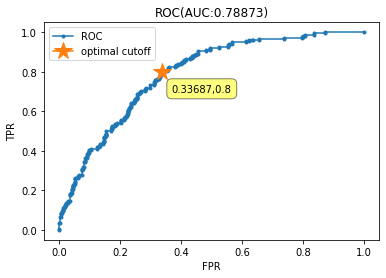

In [5]:
# 加载挑出的模型，计算 ROC 曲线、最佳阈值及 AUC 值
checkpoint_net_fe = torch.load('.//ckp//opg//auc//auc788d_ep_1798_2022_02_04_18_58_46.pth')
# net_fe = GAN_Dis_opengan_alpha(n_channel, n_d_feature)
net_fe = dnet
net_fe.to('cpu')
net_fe.load_state_dict(checkpoint_net_fe['model'])
net_fe.eval()
# 计算模型对数据集的预测值，此函数还会通过sigmod函数以保持输出在0-1内
emg_vec = emgdata_to_net_preds_sigmoid(data_set=val_set,net_vector=dnet)
# 用来计算ROC,AUC 的数据需要同格式，直接全部展平至一维
emg_vec = emg_vec.ravel()
# vallabel_for_auc = val_lb.ravel()
vallabel_for_auc = val_lb
auc_test =  metrics.roc_auc_score(vallabel_for_auc, emg_vec, average='micro')
# 计算roc曲线，以备后续绘制
fpr, tpr, thresholds = metrics.roc_curve(vallabel_for_auc,emg_vec)
auc_test_r = metrics.auc(fpr, tpr)
# 按约登指数计算最佳阈值点
optimals,points = Find_Optimal_Cutoff(tpr,fpr,thresholds)
# 作ROC图
plt.title('ROC(AUC:'+str('%.5g' % auc_test_r)+')')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,tpr,marker = '.',label = 'ROC')
plt.plot(points[0],points[1],marker = '*',markersize = 18,label = 'optimal cutoff')
# 在 ROC 图上标注最佳阈值点
plt.annotate(str('%.5g' % points[0])+','+str('%.5g' % points[1]), xy=(points[0],points[1]),\
     xytext=(10, -20), textcoords='offset points', \
         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.5))
# 显示图例
plt.legend()
plt.show()